In [ ]:
install.packages("knitr") 

#installs knitr, a package used to render tables here.
#it's here because we didn't use it in class. No need to run this if you have it already.

## Project Report

**Introduction**

Tennis is a sport that is played using a racket and a rubber ball. It can be played with either one or two players on each team, and only 2 teams play at a time. The objective of the game is to pass the ball over the net in such a way so that the opponent is unable to return the ball. For every time the opponent misses the ball, the team earns points. The first team to reach the specified number of points wins a game, and after winning 6 games, the team is said to have won a "set". The first team to win 3 sets wins the match. Every year a new season starts. Throughout the seasons, players travel around the world to attend differnet tournaments. For each winning match, these players earn points that are used to rank them. Therefore, each player gets a rank corresponding to the number of wins. Throughout tennis history, there has been great battles between veterans to attain the top spot and become the best tennis player of all time. [1]

In our data analysis, we aim to answer the following question: “What relationship does a player’s current ranking, number of seasons played, and prize money have on a player’s best ranking?” We will be using the “Player Stats for Top 500 Players” dataset which includes statistical information about the top 500 tennis players in the world. Specifically, we will focus on the following variables: “Age, Prize Money, Seasons, Current Rank, and Best Rank”. We will use knn regression to do this analysis.

**Methods and Results**

In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(tidymodels))
suppressMessages(library(repr))
suppressMessages(library(GGally))
suppressMessages(library(knitr))



set.seed(4747) #hex decimal of g is 47, we are group 47. Thus: 4747 = g47

Here we load all the libraries which we will be using to do the analysis on our dataset.

In [3]:
ifelse(file.exists("data"), stop("File already exists. If CSV file isn't downloaded, delete data folder"), dir.create("data"))
#checks if directory exists, to prevent possible errors with r kernel crashing from running this twice.


url <- "https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS"
download.file(url, "data/top500players.csv") # creates directory "data" and downloads the data used into the folder

### RUN THIS BLOCK ONLY ONCE 

ERROR: Error in ifelse(file.exists("data"), stop("File already exists. If CSV file isn't downloaded, delete data folder"), : File already exists. If CSV file isn't downloaded, delete data folder


In this code block, we download the data from the website and store it in a folder named data and name the file "top500players.csv".

In [4]:
player_data <- read_csv("data/top500players.csv", show_col_types = FALSE)
glimpse(player_data)

New names:
* `` -> ...1



Rows: 500
Columns: 38
$ ...1               <dbl> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1~
$ Age                <chr> "26 (25-04-1993)", "18 (22-12-2001)", "32 (03-11-19~
$ Country            <chr> "Brazil", "United Kingdom", "Slovakia", "Korea, Rep~
$ Plays              <chr> "Right-handed", "Left-handed", "Right-handed", "Rig~
$ Wikipedia          <chr> "Wikipedia", "Wikipedia", "Wikipedia", "Wikipedia",~
$ `Current Rank`     <chr> "378 (97)", "326 (119)", "178 (280)", "236 (199)", ~
$ `Best Rank`        <chr> "363 (04-11-2019)", "316 (14-10-2019)", "44 (14-01-~
$ Name               <chr> "Oscar Jose Gutierrez", "Jack Draper", "Lukas Lacko~
$ Backhand           <chr> NA, "Two-handed", "Two-handed", "Two-handed", "Two-~
$ `Prize Money`      <chr> NA, "$59,040", "US$3,261,567", "$374,093", "US$6,09~
$ Height             <chr> NA, NA, "185 cm", NA, "193 cm", NA, NA, NA, NA, NA,~
$ `Favorite Surface` <chr> NA, NA, "Fast (H, G) 40%", NA, "Fast (H, G) 36%", "~
$ `Turned Pro`    

In this code block we use the method read_csv() to read the data file by using it's relative path. We also display a small subset of the data to see the columns and how the data is displayed using the function glimpse(). We name the data frame after reading the data as player_data.

In [5]:
colnames(player_data) <- make.names(colnames(player_data))
player_data_tidy <- player_data %>%
                        separate(Best.Elo.Rank, c("Best.Rank", NA), sep = " ") %>% #Removes the date next to the all-time best ranks
                        separate(Current.Elo.Rank, c("Current.Rank", NA), sep = " ") %>% #Removes the elo next to the ranks
                        separate(Age, c("Age", NA), sep = " ") %>%
                            select(Name, Age, Prize.Money, Seasons, Current.Rank, Best.Rank) %>%
                         mutate(Prize.Money = gsub("[a-zA-Z$, -]", "", Prize.Money)) %>% #removes all string chars next to numbers, US$ etc.
                         mutate(Prize.Money = as.numeric(Prize.Money)) %>%
                         mutate(Best.Rank = as.numeric(Best.Rank)) %>%
                         mutate(Current.Rank = as.numeric(Current.Rank)) %>%
                         mutate(Age = as.numeric(Age)) %>%
                        na.omit()

kable(head(player_data_tidy),
      caption = "Table 1.0")



Table: Table 1.0

|Name                  | Age| Prize.Money| Seasons| Current.Rank| Best.Rank|
|:---------------------|---:|-----------:|-------:|------------:|---------:|
|Lukas Lacko           |  32|     3261567|      14|          144|        60|
|Bernard Tomic         |  27|     6091971|      11|          100|        21|
|Hubert Hurkacz        |  22|     1517157|       5|           33|        33|
|Sanjar Fayziev        |  25|      122734|       5|          189|       187|
|Felix Auger Aliassime |  19|     1893476|       3|           51|        30|
|Daniil Medvedev       |  23|    10507693|       5|            5|         4|

In this code block, we wrangled the data and tidied it. In our original data, we had the date next to the best rank. To make our data more readable, we wanted to only include a number. We did this using the separate() function. We used this same function to remove the points scored in Current.Rank and all the string chars next to the numbers such as currency from the Prize.Money column. Then, we stored the columns Prize.money, Current.Rank, Best.Rank and Age as numeric data.


Below, we will use scatter plots to compare the relationships between our variables. This will give us an overview about how each variable affects a player's best ranking. It will also help us determine which variables to omit as it may affect the accuracy of our predictions.

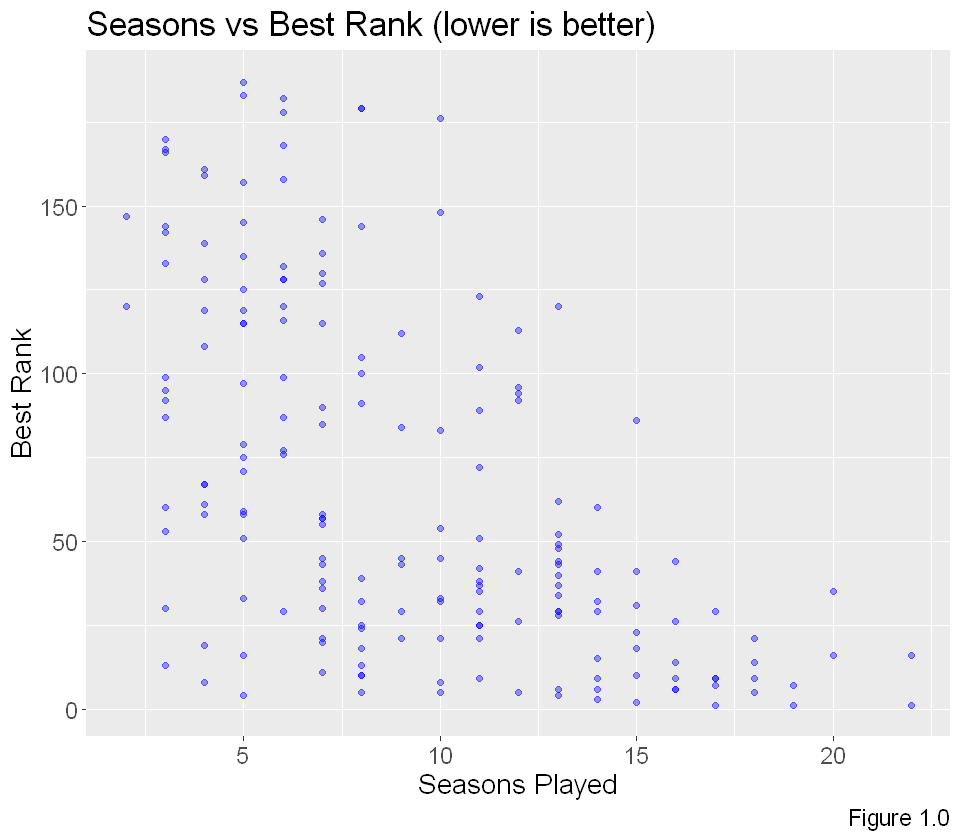

In [6]:
options(repr.plot.length = 10, repr.plot.width = 8)

SeasonsVsBestRank <- ggplot(player_data_tidy, aes(x = Seasons, y = Best.Rank)) + 
                    # geom_smooth(method = "lm", colour = "red", formula = y ~ x, se = FALSE) + #Line of best fit, helps in seeing relationship
                    geom_point(colour = "blue", alpha = 0.4) +
                     labs(x = "Seasons Played", y = "Best Rank", 
                          title = "Seasons vs Best Rank (lower is better)",
                          caption = "Figure 1.0") + 
                     theme(text = element_text(size = 17))

SeasonsVsBestRank

In figure 1.0, we are comparing the seasons played to best rank. It appears that these variables have a negative relationship—y tends to decrease as x increases. This means that players who have played more seasons tend to have a higher best rank. The overall shape is roughly linear and the relationship between the variables is fairly strong as the y variable reliably decreases as x increases.

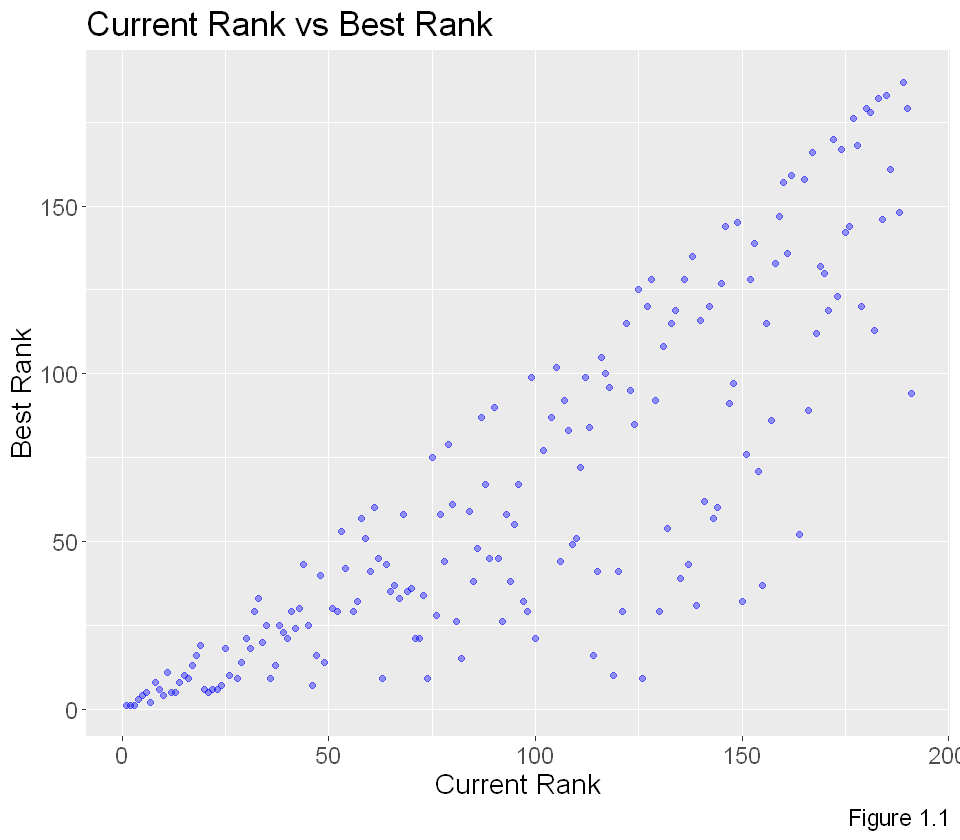

In [7]:
CurrentRankVsBestRank <- ggplot(player_data_tidy, aes(x = Current.Rank, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Current Rank", y = "Best Rank",
                          title = "Current Rank vs Best Rank",
                          caption = "Figure 1.1") + 
                     theme(text = element_text(size = 17)) 

CurrentRankVsBestRank

In figure 1.1, we are comparing a player's current rank to best rank. It appears that these variables have a positive relationship—y tends to increase as x increases. This means that players who have a high current ranking tend to also have a high best ranking. We also noticed that the y value is always equal or less than the x value. That is because a player's current ranking (x value) can not exceed their best ranking (y value)—their current ranking is either equal to their best ranking or at a lower rank. The overall shape is roughly linear and the relationship between the variables is fairly strong as the y variable reliably increases as x increases.

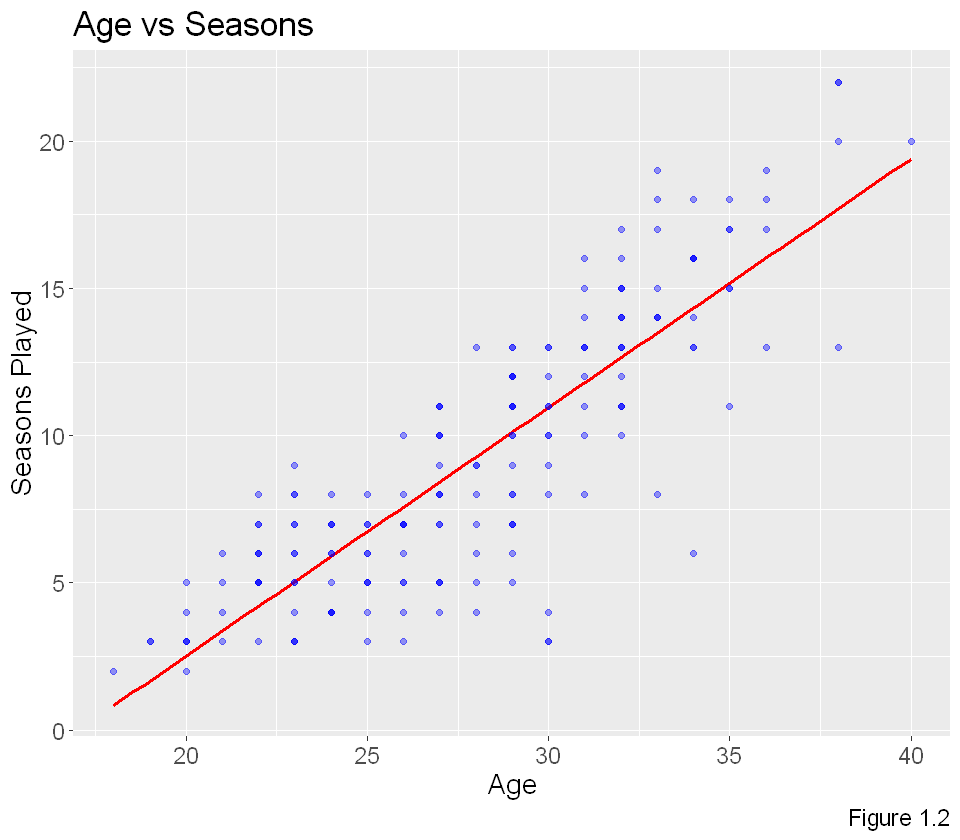

In [8]:
AgeVsSeasons <- ggplot(player_data_tidy, aes(x = Age, y = Seasons)) + 
                    geom_smooth(method = "lm", colour = "red", formula = y ~ x, se = FALSE) + #Line of best fit, helps in seeing relationship
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Age", y = "Seasons Played",
                          title = "Age vs Seasons",
                          caption = "Figure 1.2") + 
                     theme(text = element_text(size = 17)) 

AgeVsSeasons

In figure 1.2, we can see that the variables Age and seasons are very strongly correlated and have a close relationship with each other. Due to this relationship, multicollinearity can be caused and it lead to problems. For this reason, we will omit Age as a predictor variable and use Seasons instead in our analysis.

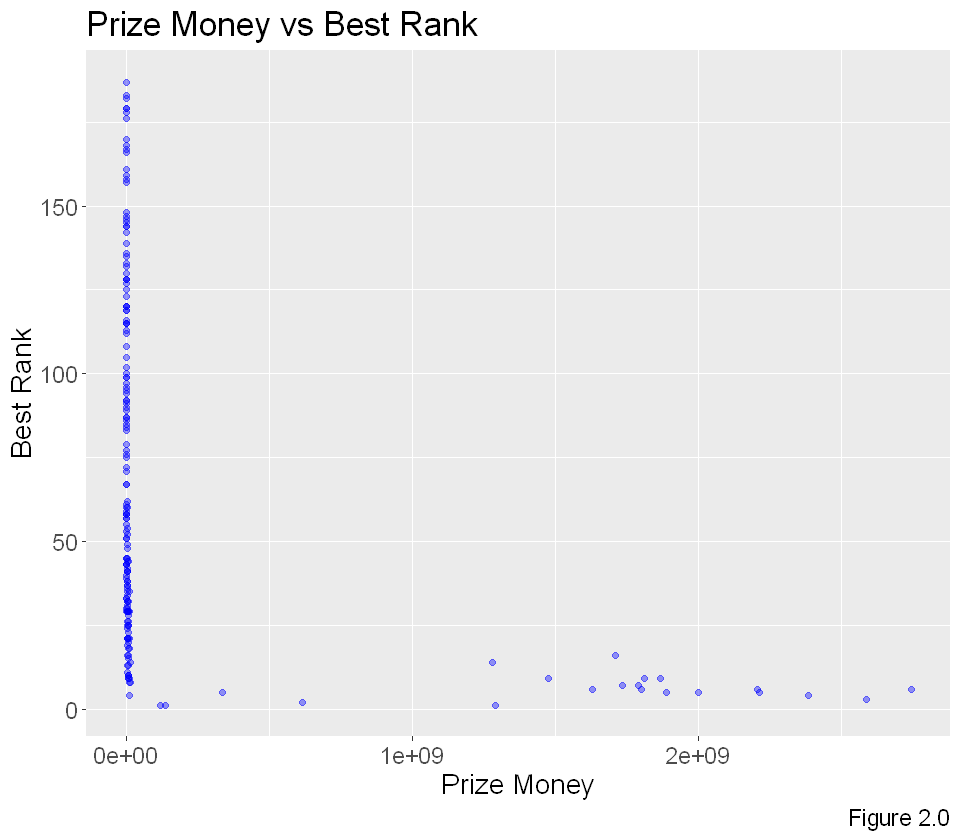

In [9]:
PrizeMoneyVsBestRank <- ggplot(player_data_tidy, aes(x = Prize.Money, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Prize Money", y = "Best Rank",
                          title = "Prize Money vs Best Rank",
                          caption = "Figure 2.0") +  
                     theme(text = element_text(size = 17))

PrizeMoneyVsBestRank

In figure 2.0 we are comparing prize money to best rank. As we can see on the plot, majority of the data points are located at 0e+00. Since some of the player's prize money are at extremely high values, we are unable to properly view the majority of the data points which are located at the lower values. To fix this problem we will implement log scaling to prize money. This will make the x and y axis at similar scales so that we can properly see the relationships between these variables.

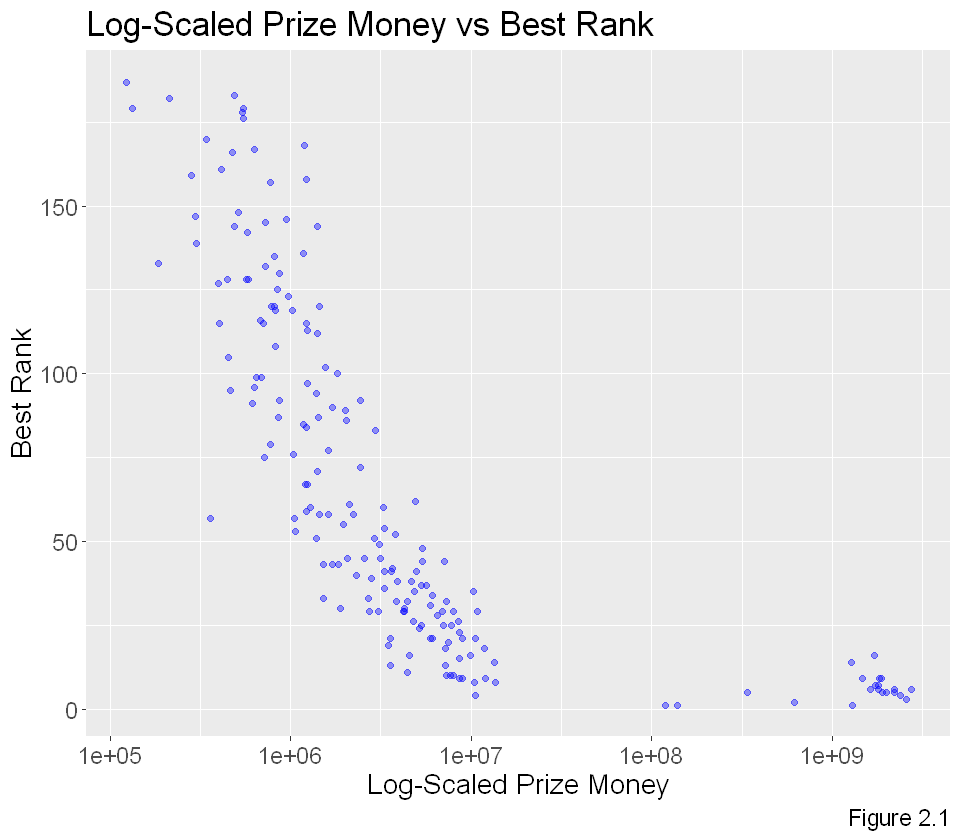

In [10]:
LogPrizeMoneyVsBestRank <- ggplot(player_data_tidy, aes(x = Prize.Money, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                     labs(x = "Log-Scaled Prize Money", y = "Best Rank",
                          title = "Log-Scaled Prize Money vs Best Rank",
                          caption = "Figure 2.1") +  
                     theme(text = element_text(size = 17)) +
                     scale_x_log10()

LogPrizeMoneyVsBestRank

In figure 2.1, prize money is log-scaled and is compared to best rank. It appears that these variables have a negative relationship—y tends to decrease as x increases. This means that players who have a higher value of prize money tend to also have a high best ranking. The overall shape is roughly linear before 1e+07 on the x axis, after this point, the data flattens out. Te relationship between the variables is fairly strong as the y variable reliably decreases as x increases.

In [11]:
log_player_data_tidy <- player_data_tidy %>%
                            mutate(Prize.Money = log(Prize.Money))

In this code, we mutate the prize money column into a log scaled value for further analysis. 

In [12]:
set.seed(4747)


player_split <- initial_split(log_player_data_tidy)
player_training <- training(player_split)
player_testing <- testing(player_split)

In [13]:
set.seed(4747)

player_vfold <- vfold_cv(player_training, v = 5, strata = Best.Rank)
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

player_recipe <- recipe(Best.Rank ~ Seasons + Prize.Money + Current.Rank, data = player_training) %>% 
                        step_scale(all_predictors()) %>%
                        step_center(all_predictors())

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("regression")

player_resamples_metrics <- workflow() %>%
                            add_model(knn_spec_tune) %>%
                            add_recipe(player_recipe) %>%
                            tune_grid(resamples = player_vfold, grid = k_vals) %>%
                            collect_metrics()

In [14]:
resamples_metrics_clean <- player_resamples_metrics %>%
                                filter(.metric == "rmse") %>%
                                arrange(mean) %>%
                                slice(1) %>%
                                select(-.estimator, -n, -.config)

kable(resamples_metrics_clean, caption = "Table 2.0")



Table: Table 2.0

| neighbors|.metric |     mean|  std_err|
|---------:|:-------|--------:|--------:|
|        10|rmse    | 16.45332| 1.157192|

In the coding above, we split the data into training and testing sets. Next, using our training data, we run cross validation to find the best k value. Using neighbors ranging from 1 to 100, we tuned the model so that it returns the RMSE for each number of neighbors. We will use the neighbor with the lowest RMSE as the best k value. In table 2.0, we used the arrange and slice function to show the neighbor that has the lowest RMSE. In this case, our best k value is 10. 

In [15]:
set.seed(4747)

best_k <- resamples_metrics_clean %>%
            select(neighbors) %>%
            pull()

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) %>%
                set_engine("kknn") %>%
                set_mode("regression")

knn_fit <- workflow() %>%
            add_model(knn_spec) %>%
            add_recipe(player_recipe) %>%
            fit(player_training) 

knn_predict <- predict(knn_fit, player_testing) %>%
                bind_cols(player_testing)

knn_metrics <- metrics(knn_predict, truth = Best.Rank, estimate = .pred)

knn_fit

== Workflow [trained] ==================================================================================================
Preprocessor: Recipe
Model: nearest_neighbor()

-- Preprocessor --------------------------------------------------------------------------------------------------------
2 Recipe Steps

* step_scale()
* step_center()

-- Model ---------------------------------------------------------------------------------------------------------------

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(10,     data, 5), kernel = ~"rectangular")

Type of response variable: continuous
minimal mean absolute error: 12.34599
Minimal mean squared error: 279.4064
Best kernel: rectangular
Best k: 10

In this code, we are evaulating the test set with k = 10. We will analyze our results using the two tables below.

In [16]:
kable(head(knn_predict), 
      caption = "Table 3.0")



Table: Table 3.0

| .pred|Name                    | Age| Prize.Money| Seasons| Current.Rank| Best.Rank|
|-----:|:-----------------------|---:|-----------:|-------:|------------:|---------:|
|  31.1|Hubert Hurkacz          |  22|    14.23235|       5|           33|        33|
|   7.0|Juan Martin Del Potro   |  31|    21.67452|      14|            4|         3|
|  39.2|Marcel Granollers       |  33|    16.19701|      14|          121|        29|
|  25.2|Fabio Fognini           |  32|    16.41602|      16|           29|        14|
|  33.0|Robin Haase             |  32|    15.77764|      13|           78|        44|
|  66.6|Roberto Carballes Baena |  26|    14.34727|       7|           90|        90|

In table 3.0, we can compare our predictions with the actual values. This table only shows the first few columns. 

In [17]:
kable(head(knn_metrics), 
      caption = "Table 3.1")



Table: Table 3.1

|.metric |.estimator |  .estimate|
|:-------|:----------|----------:|
|rmse    |standard   | 18.1065986|
|rsq     |standard   |  0.8399648|
|mae     |standard   | 12.6065217|

Table 3.1 shows us the RMSE of our KNN regression model. Our RMSE value is 18.1065986.

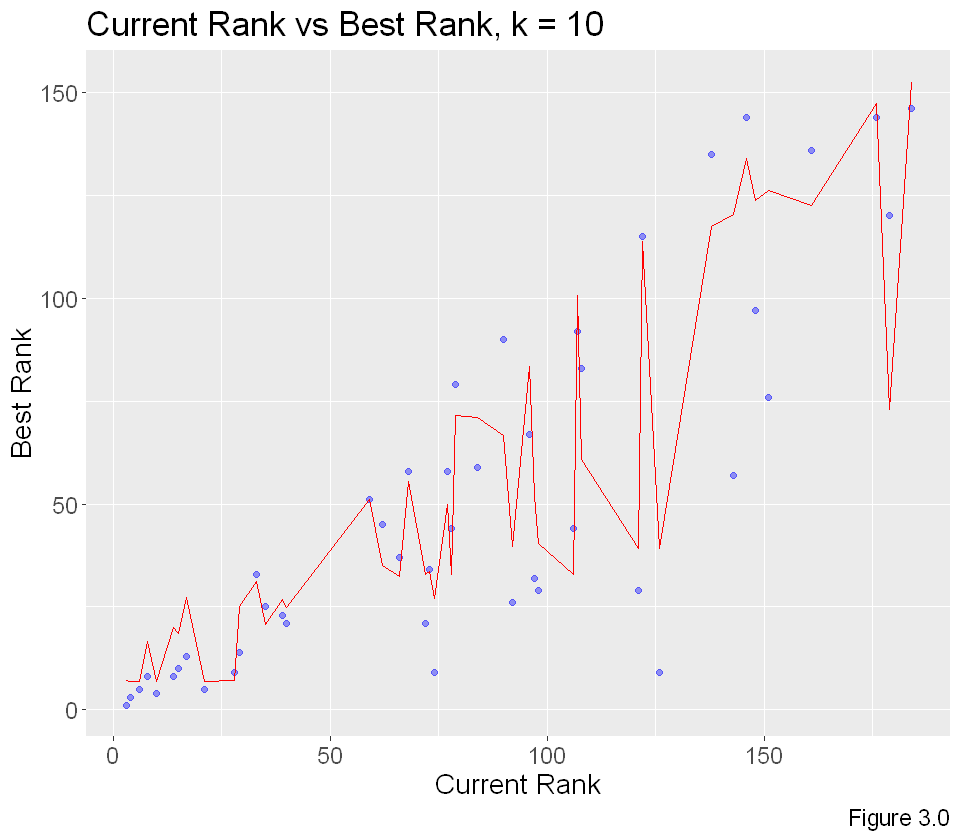

In [27]:
pred_current_rank <- ggplot(knn_predict, aes(x = Current.Rank, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                    geom_line(aes(x = Current.Rank, y = .pred), color = "red") +
                     labs(x = "Current Rank", y = "Best Rank",
                          title = paste("Current Rank vs Best Rank, k =", best_k, sep = " "),
                          caption = "Figure 3.0") +  
                     theme(text = element_text(size = 17))
pred_current_rank

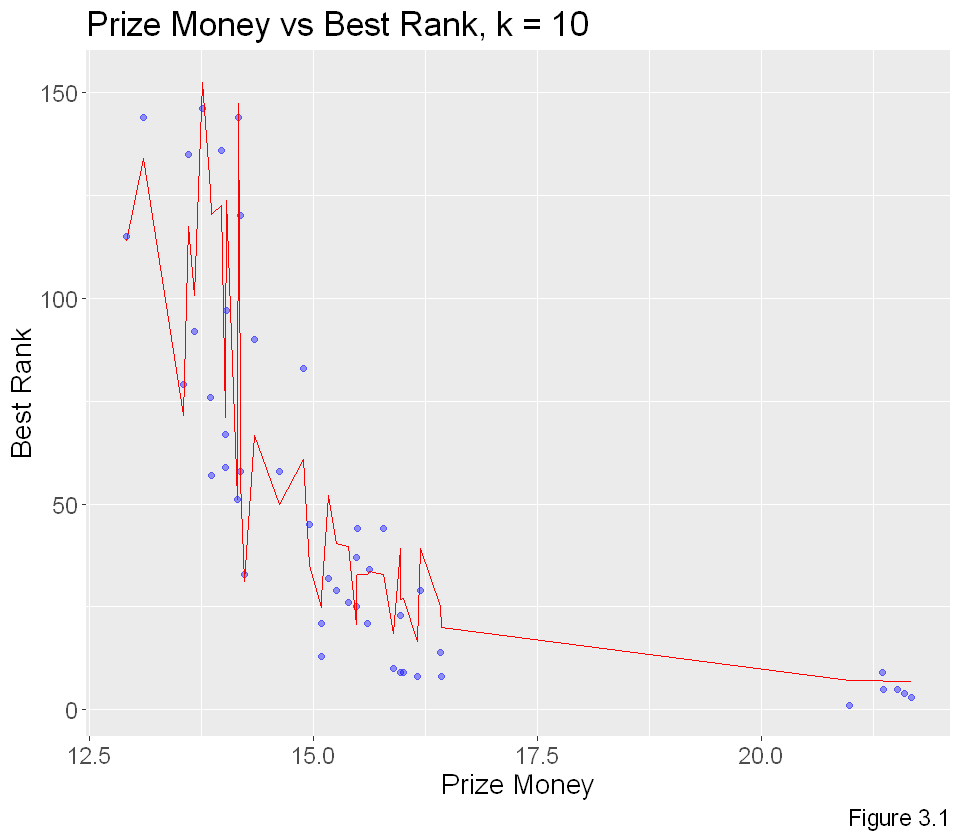

In [25]:
pred_prize_money <- ggplot(knn_predict, aes(x = Prize.Money, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                    geom_line(aes(x = Prize.Money, y = .pred), color = "red") +
                     labs(x = "Prize Money", y = "Best Rank",
                          title = paste("Prize Money vs Best Rank, k =", best_k, sep = " "),
                          caption = "Figure 3.1") +  
                     theme(text = element_text(size = 17))
pred_prize_money

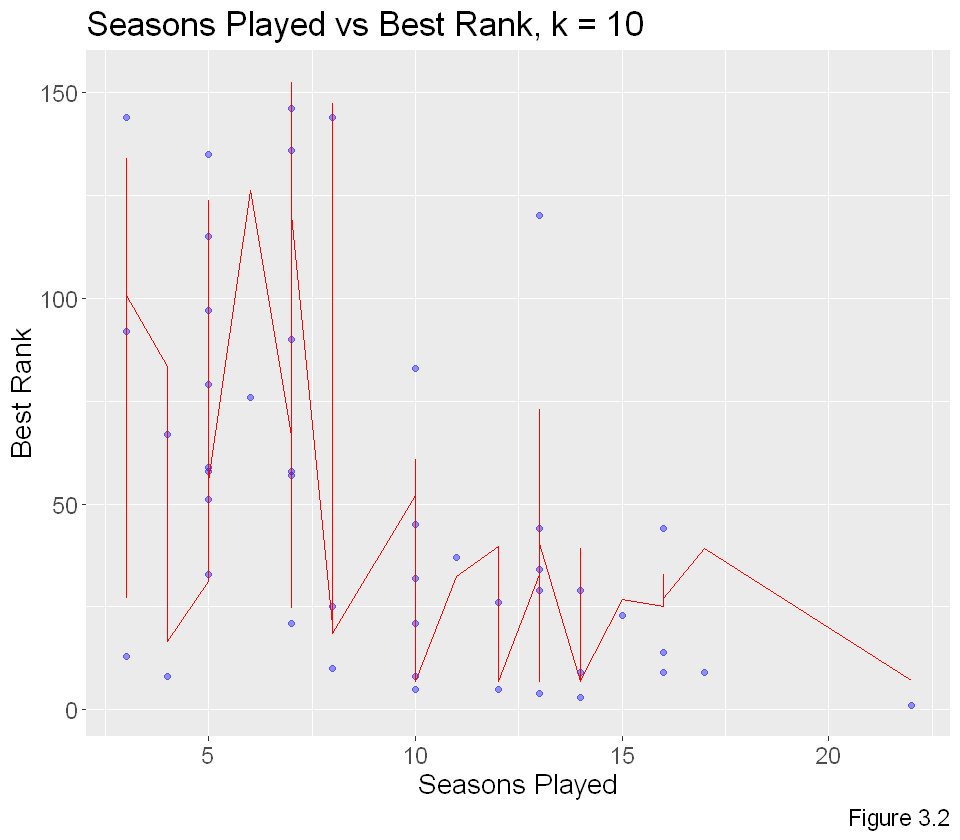

In [26]:
pred_seasons <- ggplot(knn_predict, aes(x = Seasons, y = Best.Rank)) + 
                    geom_point(color = "blue", alpha = 0.4) +
                    geom_line(aes(x = Seasons, y = .pred), color = "red") +
                     labs(x = "Seasons Played", y = "Best Rank",
                          title = paste("Seasons Played vs Best Rank, k =", best_k, sep = " "),
                          caption = "Figure 3.2") +  
                     theme(text = element_text(size = 17))
pred_seasons

**Discussion**

- These findings could help the Sport industry select potential athletes and predict their success. Sport universities could use Seasons Played and Age to determine which athletes they would like to admit in competitions.

- Using only Seasons, Prize Money and Current Rank as predictors for athlete rank is not very accurate because ranks can be influenced by many other factors which are not present in this dataset. For example, weather on the game day, psychological quality of athletes, brands of shoes and sportswear could be potential factors for athlete grades. The physical trait also matters to a great extent of their performance and rank. Future questions could focus on addressing these problems by exploring other variables that have relationships with rank. 

**References**
1. Tennis Scoring: Points, Sets & Games | Tennis Rules | USTA. (n.d.). Tennis Scoring: Points, Sets & Games | Tennis Rules | USTA. https://www.usta.com/en/home/improve/tips-and-instruction/national/tennis-scoring-rules.html.